# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

There's also a cell that allows us to step through hyperparamters for any particular model to examine how the model overfits as a hyparameter changes.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you should select your final/best model and hyperparameters to run one time only and then make the business performance tables for that final model. Note once we've decided on the final model and hyperparameters we're allowed to make several trial runs of our final model train looking for a good performance on the testing data, as long as we don't make any changes to the model hyperparameters from our final choice.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [3]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(98037, 22)
CPU times: user 260 ms, sys: 47.3 ms, total: 307 ms
Wall time: 704 ms


,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,...,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7,Recnum,Fraud
0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,1,0.0
1,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,2,0.0
2,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,3,0.0
3,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,4,0.0
4,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,5,0.0


In [4]:
# set the number of variables desired here, and set the names of the y and record label properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'card_state_total_3',
 'card_state_total_amount_1_by_60',
 'Cardnum_max_14',
 'card_zip_count_1_by_60',
 'card_state_count_1_by_30_sq',
 'Cardnum_count_0_by_60_sq',
 'Card_dow_unique_count_for_state_des_30',
 'Card_dow_unique_count_for_merch_state_14',
 'Card_dow_unique_count_for_merch_zip_14']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
0,1,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
1,2,0.0,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0
2,3,0.0,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0
3,4,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
4,5,0.0,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0


In [6]:
vars.shape

(98037, 12)

In [7]:
vars['Fraud'].sum()

2492.0

In [8]:
print("fraud rate in data is",(vars['Fraud'].sum()/len(vars)).round(4))

fraud rate in data is 0.0254


In [9]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
0,1,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
1,2,0.0,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0
2,3,0.0,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0
3,4,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
4,5,0.0,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
5,6,0.0,1.0,3.67,0.016667,3.67,0.016667,0.001111,0.000278,1.0,1.0,1.0
6,7,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
7,8,0.0,1.0,230.32,0.016667,230.32,0.016667,0.001111,0.000278,1.0,1.0,1.0
8,9,0.0,1.0,62.11,0.016667,62.11,0.016667,0.001111,0.000278,1.0,1.0,1.0
9,10,0.0,1.0,10.86,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0


In [10]:
vars.shape

(98037, 12)

In [11]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,98037.000000,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000
mean,49185.587992,0.025419,1.757020,733.620037,8.024469e-03,1194.259716,0.011052,0.000654,4.180968e-05,3.449922,2.333221,2.335006
std,28418.418181,0.157395,1.643117,4087.096369,6.649885e-03,1852.307476,0.006105,0.000398,5.671510e-05,3.377390,2.316602,2.317518
min,1.000000,0.000000,1.000000,0.010000,1.901394e-07,0.140000,0.000030,0.000003,5.050505e-07,1.000000,1.000000,1.000000
25%,24564.000000,0.000000,1.000000,65.540000,1.552354e-03,309.020000,0.005556,0.000278,1.068376e-05,1.000000,1.000000,1.000000
50%,49186.000000,0.000000,1.000000,217.760000,5.961863e-03,804.930000,0.016667,0.000556,2.136752e-05,2.000000,2.000000,2.000000
75%,73808.000000,0.000000,2.000000,658.000000,1.666667e-02,1741.460000,0.016667,0.001111,4.629630e-05,4.000000,3.000000,3.000000
max,98393.000000,1.000000,21.000000,306633.410000,1.666667e-02,47900.000000,0.016667,0.001111,2.777778e-04,50.000000,41.000000,41.000000


In [12]:
# find the row i vars that corresponds to 11/1 for the OOT
test = vars[vars['Recnum'] > 85725]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
85396,85726,0.0,1.0,789.32,0.016667,609.34,0.016667,0.001111,0.000278,1.0,1.0,1.0
85397,85727,0.0,1.0,235.00,0.016667,399.15,0.016667,0.001111,0.000046,1.0,1.0,1.0
85398,85728,0.0,1.0,600.00,0.016667,600.00,0.016667,0.001111,0.000278,1.0,1.0,1.0
85399,85729,0.0,1.0,30.00,0.001265,30.00,0.008333,0.000556,0.000031,1.0,1.0,1.0
85400,85730,0.0,1.0,182.00,0.004183,1573.30,0.016667,0.000556,0.000008,3.0,2.0,2.0
85401,85731,0.0,1.0,174.61,0.007283,225.00,0.008333,0.000556,0.000139,1.0,1.0,1.0
85402,85732,0.0,1.0,259.90,0.000311,395.00,0.001515,0.000159,0.000010,2.0,3.0,3.0
85403,85733,0.0,1.0,25.00,0.000346,531.25,0.005556,0.000222,0.000019,3.0,3.0,3.0
85404,85734,0.0,1.0,97.17,0.000987,395.04,0.016667,0.000556,0.000019,1.0,1.0,1.0
85405,85735,0.0,1.0,6.51,0.003082,6.51,0.005556,0.000556,0.000093,1.0,1.0,1.0


In [13]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [14]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000
mean,1.757020,733.620037,8.024469e-03,1194.259716,0.011052,0.000654,4.180968e-05,3.449922,2.333221,2.335006
std,1.643117,4087.096369,6.649885e-03,1852.307476,0.006105,0.000398,5.671510e-05,3.377390,2.316602,2.317518
min,1.000000,0.010000,1.901394e-07,0.140000,0.000030,0.000003,5.050505e-07,1.000000,1.000000,1.000000
25%,1.000000,65.540000,1.552354e-03,309.020000,0.005556,0.000278,1.068376e-05,1.000000,1.000000,1.000000
50%,1.000000,217.760000,5.961863e-03,804.930000,0.016667,0.000556,2.136752e-05,2.000000,2.000000,2.000000
75%,2.000000,658.000000,1.666667e-02,1741.460000,0.016667,0.001111,4.629630e-05,4.000000,3.000000,3.000000
max,21.000000,306633.410000,1.666667e-02,47900.000000,0.016667,0.001111,2.777778e-04,50.000000,41.000000,41.000000


In [15]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [16]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [17]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04
mean,-5.740178e-17,7.827516e-18,4.406601e-17,-2.609172e-18,-2.783117e-17,9.277056e-18,8.697240e-19,1.971374e-17,2.551190e-17,-2.899080e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.624561e-01,-3.535511e-01,-1.206679e+00,-7.218116e-01,-1.805445e+00,-1.635089e+00,-7.282828e-01,-7.301471e-01,-5.910956e-01,-5.916135e-01
25%,-4.624561e-01,-3.196503e-01,-9.732673e-01,-5.323110e-01,-9.003706e-01,-9.442087e-01,-5.488119e-01,-7.301471e-01,-5.910956e-01,-5.916135e-01
50%,-4.624561e-01,-2.409018e-01,-3.101716e-01,-2.280658e-01,9.197603e-01,-2.467484e-01,-3.604359e-01,-4.318418e-01,-1.457875e-01,-1.465178e-01
75%,1.490252e-01,-1.315083e-02,1.299601e+00,3.465037e-01,9.197603e-01,1.148172e+00,7.910798e-02,1.647688e-01,2.995206e-01,2.985779e-01
max,1.004780e+01,2.116989e+01,1.299601e+00,1.137486e+01,9.197603e-01,1.148172e+00,4.160587e+00,1.007561e+01,1.031861e+01,1.031776e+01


In [18]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this OOT record number to whatever is appropriate for your data
oot_recnum = 85400
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    356.0
dtype: float64

## Look at PCA

In [19]:
len(X_trntst.columns)

10

In [20]:
X_trntst_save = X_trntst.copy()

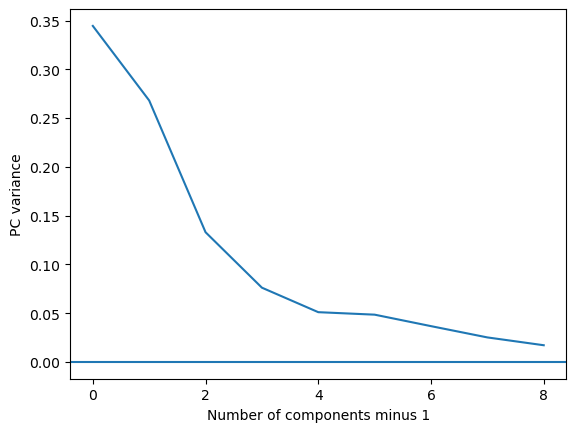

In [21]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [22]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-2.298592,2.828930,-1.044553,2.853312
1,-2.294038,2.831059,-1.023337,2.855314
2,-2.269947,2.842318,-0.911097,2.865906
3,-2.298592,2.828930,-1.044553,2.853312
4,-2.298448,2.829098,-1.043171,2.853872


In [23]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85400,-0.271263,-0.301918,0.152177,-0.789034
85401,-1.411576,-0.134906,-0.549871,1.599018
85402,0.354204,-2.270881,-0.356633,0.329590
85403,0.396363,-1.803357,-0.444931,0.211623
85404,-1.111503,-0.669822,-0.198713,-0.544822


In [24]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000
mean,0.005402,0.001902,-0.007191,0.003646,-0.016853,-0.016394,0.000793,0.018604,0.004191,0.004150
std,1.010079,1.015093,1.000565,0.986430,1.008559,1.003052,1.015169,1.025655,1.015940,1.015793
min,-0.462456,-0.353551,-1.206679,-0.721812,-1.805445,-1.635089,-0.728283,-0.730147,-0.591096,-0.591614
25%,-0.462456,-0.319930,-0.978909,-0.528642,-0.900371,-0.944209,-0.555789,-0.730147,-0.591096,-0.591614
50%,-0.462456,-0.241329,-0.325085,-0.219636,0.822253,-0.246748,-0.360436,-0.431842,-0.145788,-0.146518
75%,0.149025,-0.013151,1.299601,0.354197,0.919760,1.148172,0.079108,0.164769,0.299521,0.298578
max,10.047803,21.169890,1.299601,11.374863,0.919760,1.148172,4.160587,10.075611,10.318614,10.317765


In [25]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.162351,0.136121,0.000288,-0.086914
std,1.661656,1.508477,1.103300,0.810441
min,-2.298898,-2.868975,-4.088040,-2.742315
25%,-1.155412,-1.110489,-0.429237,-0.622208
50%,-0.553779,-0.026500,-0.214440,-0.135327
75%,0.352563,1.480842,0.188719,0.283837
max,17.779793,7.010407,22.850611,6.264188


In [26]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [27]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.540000e+04,85400.000000,8.540000e+04,8.540000e+04
mean,1.597473e-17,0.000000,3.328069e-18,-5.324910e-18
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
min,-1.226852e+00,-1.775766,-4.261524e+00,-3.258578e+00
25%,-5.685818e-01,-0.822654,-3.813573e-01,-6.515316e-01
50%,-2.173434e-01,-0.128616,-1.719380e-01,-5.239055e-02
75%,2.924765e-01,0.890179,1.811218e-01,4.049477e-01
max,1.149504e+01,4.654491,1.977602e+01,7.850799e+00


In [28]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.086632,0.082347,0.000247,-0.098665
std,0.886675,0.912554,0.947611,0.920021
min,-1.226713,-1.735588,-3.511168,-3.113102
25%,-0.616539,-0.671791,-0.368667,-0.706336
50%,-0.295502,-0.016031,-0.184180,-0.153624
75%,0.188131,0.895836,0.162089,0.322214
max,9.487463,4.240950,19.626115,7.111166


In [29]:
X_trntst_pca.shape

(85400, 4)

In [30]:
X_oot_orig_pca.shape

(12637, 4)

## Subsample the larger class if desired

In [31]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.025011709601873537
(4219, 10) 4219


In [32]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [33]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [34]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.652 0.656 0.542
1 0.656 0.649 0.542
2 0.645 0.67 0.539
3 0.659 0.63 0.539
4 0.65 0.654 0.537
5 0.649 0.652 0.534
6 0.667 0.629 0.545
7 0.644 0.668 0.534
8 0.651 0.661 0.542
9 0.66 0.635 0.545
trn    0.653
tst    0.650
oot    0.540
dtype: float64
CPU times: user 4min 16s, sys: 618 ms, total: 4min 16s
Wall time: 32.1 s


In [35]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion='gini', 
                                   splitter='random',
                                   max_depth = 12,
                                   min_samples_split=80, 
                                   min_samples_leaf=40
                                  )
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.675 0.652 0.542
1 0.69 0.646 0.573
2 0.665 0.662 0.528
3 0.685 0.678 0.545
4 0.673 0.645 0.556
5 0.657 0.677 0.565
6 0.651 0.679 0.542
7 0.643 0.66 0.531
8 0.669 0.657 0.553
9 0.665 0.667 0.545
trn    0.667
tst    0.662
oot    0.548
dtype: float64
CPU times: user 938 ms, sys: 18.2 ms, total: 956 ms
Wall time: 868 ms


In [36]:
# %%time
# # RF

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = RandomForestClassifier()
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [37]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(boosting_type='gbdt', 
                               num_leaves=100, 
                               max_depth=3, 
                               learning_rate=0.05, 
                               n_estimators=100,
                              verbosity =-1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.741 0.711 0.576
1 0.745 0.686 0.565
2 0.729 0.716 0.573
3 0.742 0.705 0.556
4 0.733 0.722 0.565
5 0.738 0.695 0.57
6 0.742 0.713 0.562
7 0.726 0.731 0.573
8 0.734 0.719 0.565
9 0.739 0.716 0.567
trn    0.737
tst    0.712
oot    0.567
dtype: float64
CPU times: user 19.8 s, sys: 1.52 s, total: 21.3 s
Wall time: 2.71 s


In [38]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     sm = SMOTE()
    
#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier(boosting_type='gbdt', 
#                                    num_leaves=100, 
#                                    max_depth=3, 
#                                    learning_rate=0.05, 
#                                    n_estimators=100,
#                                     verbosity =-1)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [39]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [40]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    model = MLPClassifier(hidden_layer_sizes=(10,8,6,4,2), 
                          activation='relu', 
                          solver='adam', 
                          alpha=0.001,
                          learning_rate='constant',
                          max_iter=150)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.729 0.707 0.576
1 0.723 0.688 0.618
2 0.703 0.686 0.584
3 0.709 0.664 0.579
4 0.707 0.703 0.579
5 0.719 0.706 0.601
6 0.735 0.703 0.579
7 0.706 0.707 0.562
8 0.697 0.675 0.562
9 0.725 0.688 0.545
trn    0.715
tst    0.693
oot    0.578
dtype: float64
CPU times: user 3min 20s, sys: 839 ms, total: 3min 21s
Wall time: 3min 3s


In [41]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(1,1))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [42]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [43]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(
                                iterations=1000,
                                learning_rate=0.005,
                                depth=8,
                                l2_leaf_reg=4,
                                border_count=150,
                                random_seed=42,
                                verbose=False
                            )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.763 0.773 0.587
1 0.781 0.753 0.59
2 0.784 0.735 0.587
3 0.78 0.739 0.581
4 0.788 0.732 0.587
5 0.773 0.759 0.596
6 0.776 0.75 0.584
7 0.773 0.752 0.59
8 0.78 0.748 0.587
9 0.775 0.732 0.59
trn    0.777
tst    0.747
oot    0.588
dtype: float64
CPU times: user 14min 2s, sys: 5min 20s, total: 19min 22s
Wall time: 2min 27s


In [44]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = lgb.LGBMClassifier()

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [45]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [46]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [47]:
%%time
# XGB

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(booster="gbtree",
                                learning_rate=0.05,
                                n_estimators=30,
                                max_depth=7,
                                gamma=5,
                                reg_lambda=5
                             )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.766 0.7 0.598
1 0.765 0.719 0.581
2 0.762 0.719 0.581
3 0.757 0.723 0.57
4 0.744 0.746 0.57
5 0.761 0.702 0.581
6 0.755 0.702 0.584
7 0.76 0.725 0.581
8 0.756 0.719 0.584
9 0.765 0.711 0.587
trn    0.759
tst    0.717
oot    0.582
dtype: float64
CPU times: user 11.2 s, sys: 100 ms, total: 11.3 s
Wall time: 2.13 s


In [48]:
%%time
# Knn
# Knn can be very slow with a lot of records.

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    model = KNeighborsClassifier(n_neighbors=12) 
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.785 0.716 0.587
1 0.774 0.703 0.57
2 0.76 0.726 0.593
3 0.766 0.736 0.581
4 0.771 0.716 0.584
5 0.767 0.724 0.57
6 0.782 0.703 0.567
7 0.762 0.72 0.562
8 0.776 0.7 0.567
9 0.771 0.699 0.573
trn    0.771
tst    0.714
oot    0.576
dtype: float64
CPU times: user 1min 46s, sys: 670 ms, total: 1min 47s
Wall time: 1min 47s


In [49]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean().round(3))
# model_counter = model_counter + 1

## Model comparison plots

In [50]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.651997,0.655539,0.542135
1,log reg,0.65566,0.648773,0.542135
2,log reg,0.645225,0.670382,0.539326
3,log reg,0.65903,0.630368,0.539326
4,log reg,0.650134,0.653727,0.536517
5,log reg,0.649449,0.652047,0.533708
6,log reg,0.666886,0.628664,0.544944
7,log reg,0.643955,0.668232,0.533708
8,log reg,0.651163,0.660856,0.542135
9,log reg,0.659987,0.634975,0.544944


In [51]:
df.shape

(70, 4)

In [52]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], \
                     var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.651997
1,log reg,Trn,0.65566
2,log reg,Trn,0.645225
3,log reg,Trn,0.65903
4,log reg,Trn,0.650134


In [53]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.651997
1,log reg,Trn,0.65566
2,log reg,Trn,0.645225
3,log reg,Trn,0.65903
4,log reg,Trn,0.650134


In [54]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.667268  0.014598  0.662382  0.012710  0.548034  0.014042
Knn        0.771326  0.008085  0.714314  0.012740  0.575562  0.010124
LGBM       0.736825  0.006172  0.711551  0.013286  0.567135  0.005988
NN         0.715452  0.012349  0.692534  0.014882  0.578371  0.020533
XGB        0.759192  0.006422  0.716548  0.014047  0.582022  0.008033
cat boost  0.777242  0.006777  0.747334  0.013096  0.587921  0.003757
log reg    0.653349  0.007081  0.650356  0.014836  0.539888  0.004145

In [55]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.651997,0.655539,0.542135
1,log reg,0.65566,0.648773,0.542135
2,log reg,0.645225,0.670382,0.539326
3,log reg,0.65903,0.630368,0.539326
4,log reg,0.650134,0.653727,0.536517


In [56]:
best_OOT = df['OOT'].max()
best_OOT

0.6179775280898876

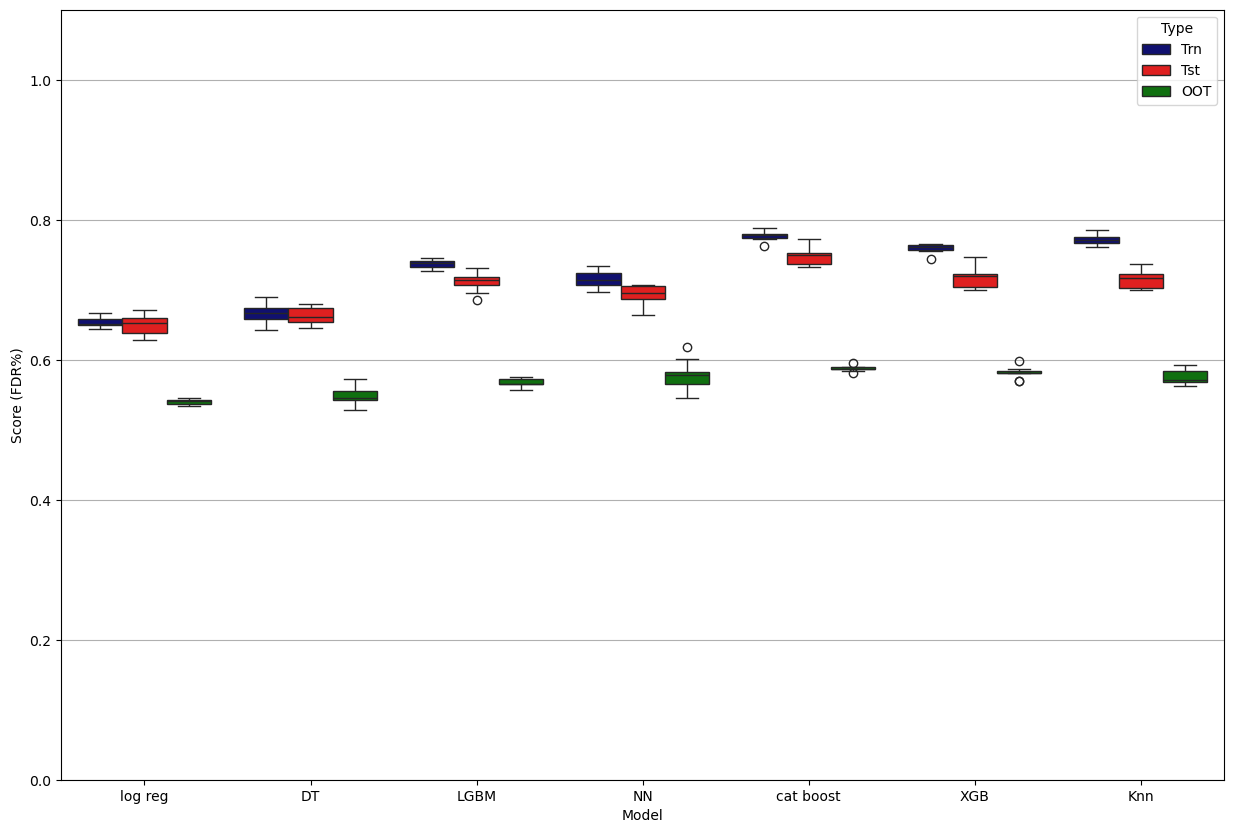

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(0.,1.1)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [58]:
print('duration: ', datetime.now() - start_time)

duration:  0:08:01.356183


This below cells are used to explore overfitting

In [59]:
%%time
nitermax2 = 3 # let's reduce the number of runs to make it faster
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,14,1):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
 
        model = DecisionTreeClassifier(max_depth=i)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

0 0.44214876033057854 0.42543859649122806 0.351123595505618
1 0.42985487214927437 0.4455732946298984 0.351123595505618
2 0.4381720430107527 0.4351851851851852 0.351123595505618
loop trn tst oot 1 0.14557507505451173 0.14513300847847907 0.11704119850187267
0 0.543403964456596 0.5542347696879644 0.4297752808988764
1 0.5575880758807588 0.5227272727272727 0.4353932584269663
2 0.5572987721691678 0.5283582089552239 0.4297752808988764
loop trn tst oot 2 0.18425453472294695 0.1783689168189401 0.14388264669163547
0 0.6255924170616114 0.6176024279210925 0.5028089887640449
1 0.6149802890932983 0.6351791530944625 0.5056179775280899
2 0.6153846153846154 0.6162246489859594 0.47752808988764045
loop trn tst oot 3 0.20621748017105834 0.20766735888905716 0.16510611735330835
0 0.6608108108108108 0.6204268292682927 0.5224719101123596
1 0.6325706594885598 0.6446153846153846 0.49157303370786515
2 0.6455696202531646 0.6535433070866141 0.5168539325842697
loop trn tst oot 4 0.2154390100613928 0.213176168996699

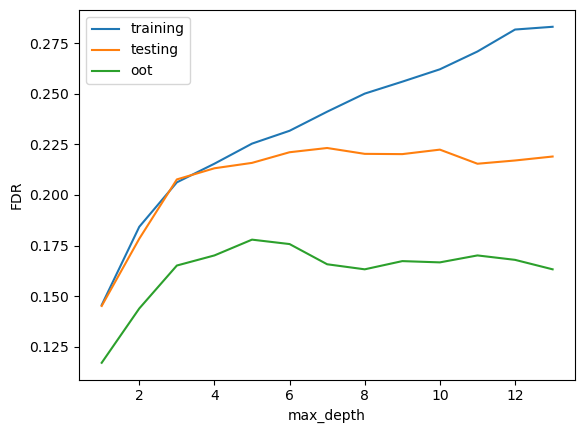

In [60]:
table=pd.DataFrame({'n': range(1, 14, 1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
ax = table.plot(xlabel = "max_depth", ylabel = "FDR")
plt.savefig('complexity_NN.png', format='png')
plt.show()

In [61]:
%%time
nitermax2 = 3 # let's reduce the number of runs to make it faster
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(201,0,-10):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
 
        model = xgb.XGBClassifier(min_child_weight = i)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

0 0.6862091938707529 0.6787401574803149 0.5280898876404494
1 0.692154255319149 0.6566455696202531 0.5168539325842697
2 0.7000663570006636 0.6454689984101749 0.5337078651685393
loop trn tst oot 201 0.6928099353968552 0.660284908503581 0.5262172284644194
0 0.6868754163890739 0.6929133858267716 0.5280898876404494
1 0.6763513513513514 0.6951219512195121 0.5280898876404494
2 0.6872536136662286 0.7296416938110749 0.5308988764044944
loop trn tst oot 191 0.6834934604688847 0.7058923436191195 0.5290262172284644
0 0.6954760297096556 0.7099236641221374 0.5533707865168539
1 0.6970310391363023 0.7033639143730887 0.5308988764044944
2 0.6915322580645161 0.6975308641975309 0.5393258426966292
loop trn tst oot 181 0.6946797756368247 0.7036061475642522 0.5411985018726592
0 0.6987951807228916 0.7009345794392523 0.5421348314606742
1 0.6949035812672176 0.7032163742690059 0.5308988764044944
2 0.7031778228532792 0.6971080669710806 0.5449438202247191
loop trn tst oot 171 0.698958861614463 0.7004196735597796 0.

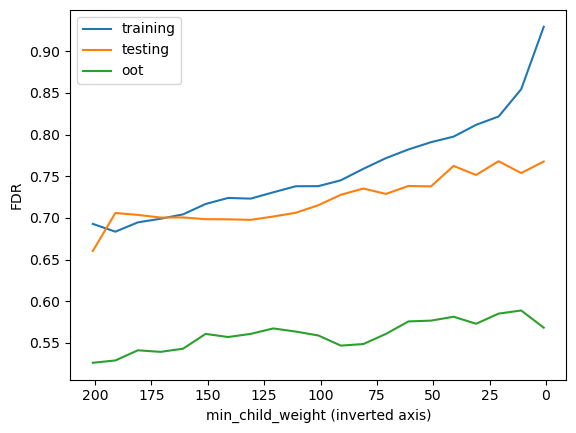

In [62]:
table=pd.DataFrame({'n': range(201,0,-10),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
ax = table.plot(xlabel = "min_child_weight (inverted axis)", ylabel = "FDR")
ax.invert_xaxis()
plt.savefig('complexity_XGB.png', format='png')
plt.show()

In [63]:
%%time
nitermax2 = 3 # let's reduce the number of runs to make it faster
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(2,1000,10):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
 
        model = lgb.LGBMClassifier(num_leaves=i, verbosity = -1)


        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        # print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    # print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

CPU times: user 1h 27min 14s, sys: 33.7 s, total: 1h 27min 47s
Wall time: 10min 59s


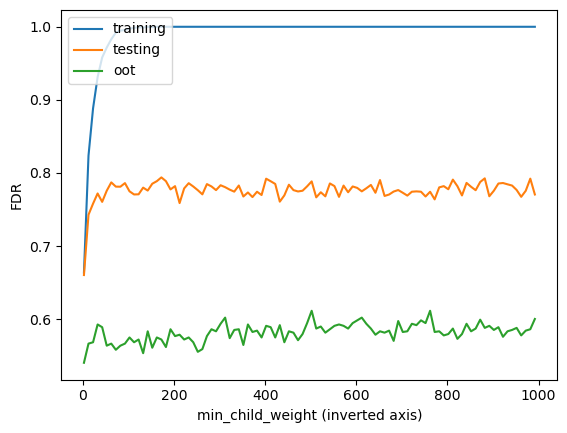

In [64]:
table=pd.DataFrame({'n': range(2,1000,10),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
ax = table.plot(xlabel = "min_child_weight (inverted axis)", ylabel = "FDR")
plt.savefig('complexity_XGB.png', format='png')
plt.show()

In [59]:
best_OOT

0.6179775280898876

# Final Model

The rest of the notebook makes the tables for the final model of choice. We need to run that final model only once (no CV). We can run the below cell over and over by itself until it gives ua a model we like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [63]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nomber of times with your fixed hyperparameters until it finds a good model.
# desire = best_OOT * .95
desire = .601
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where we put our final model of choice
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice
    model = CatBoostClassifier(
                                iterations=500,
                                learning_rate=0.01,
                                depth=8,
                                l2_leaf_reg=4,
                                border_count=150,
                                random_seed=42,
                                verbose=False
                            )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.601
0 0.7585526315789474 0.7727272727272727 0.5955056179775281
1 0.7794216543375925 0.7411402157164869 0.5955056179775281
2 0.775065963060686 0.7564516129032258 0.5842696629213483
3 0.7782956058588548 0.7318611987381703 0.5842696629213483
4 0.7691292875989446 0.7709677419354839 0.5898876404494382
5 0.7792823290453622 0.7344461305007587 0.5842696629213483
6 0.7778528021607022 0.7480916030534351 0.601123595505618
CPU times: user 4min 42s, sys: 1min 54s, total: 6min 36s
Wall time: 50.7 s


In [64]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [65]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,predicted,Fraud
92216,7.486801,-0.080290,1.299601,-0.120659,0.91976,1.148172,-0.611604,-0.730147,-0.591096,-0.591614,0.956852,1.0
96865,6.875320,-0.342341,1.299601,-0.188893,0.91976,1.148172,-0.524241,-0.730147,-0.591096,-0.591614,0.951293,1.0
94561,7.486801,-0.343830,1.299601,-0.114904,0.91976,1.148172,0.759355,3.446127,4.307294,4.304440,0.948576,1.0
89488,6.263838,-0.346169,1.299601,-0.219391,0.91976,1.148172,1.458366,2.849517,4.752602,4.749535,0.947769,0.0
91519,8.098282,-0.330452,1.299601,-0.185820,0.91976,1.148172,2.431961,5.534264,7.869758,7.865206,0.947753,1.0
91507,7.486801,-0.343360,1.299601,-0.185820,0.91976,1.148172,2.379578,5.235959,7.424450,7.420110,0.947273,1.0
96784,7.486801,-0.342175,1.299601,-0.188893,0.91976,1.148172,1.956588,2.252906,3.861985,3.859344,0.944719,1.0
94521,6.875320,-0.346236,1.299601,-0.114904,0.91976,1.148172,0.662176,3.147822,3.861985,3.859344,0.944535,1.0
92158,5.652357,-0.347478,1.299601,-0.120659,0.91976,1.148172,1.439601,3.744433,5.643218,5.639727,0.944245,1.0
91532,8.098282,0.125029,0.110147,-0.185820,0.91976,0.590204,2.481350,5.832570,8.315067,8.310301,0.943952,0.0


In [66]:
cost_fraud = 400
cost_fp = 20
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,126.0,22.0,104.0,17.460317,82.539683,126.0,22.0,104.0,0.179139,29.213483,29.034345,0.211538
2,2.0,127.0,52.0,75.0,40.944882,59.055118,253.0,74.0,179.0,0.602557,50.280899,49.678342,0.413408
3,3.0,126.0,91.0,35.0,72.222222,27.777778,379.0,165.0,214.0,1.343539,60.112360,58.768821,0.771028
4,4.0,126.0,109.0,17.0,86.507937,13.492063,505.0,274.0,231.0,2.231089,64.887640,62.656552,1.186147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,127.0,127.0,0.0,100.000000,0.000000,12132.0,11776.0,356.0,95.887957,100.000000,4.112043,33.078652
97,97.0,126.0,126.0,0.0,100.000000,0.000000,12258.0,11902.0,356.0,96.913932,100.000000,3.086068,33.432584
98,98.0,126.0,126.0,0.0,100.000000,0.000000,12384.0,12028.0,356.0,97.939907,100.000000,2.060093,33.786517
99,99.0,127.0,127.0,0.0,100.000000,0.000000,12511.0,12155.0,356.0,98.974025,100.000000,1.025975,34.143258


Max possible savings: 60,180,000.0


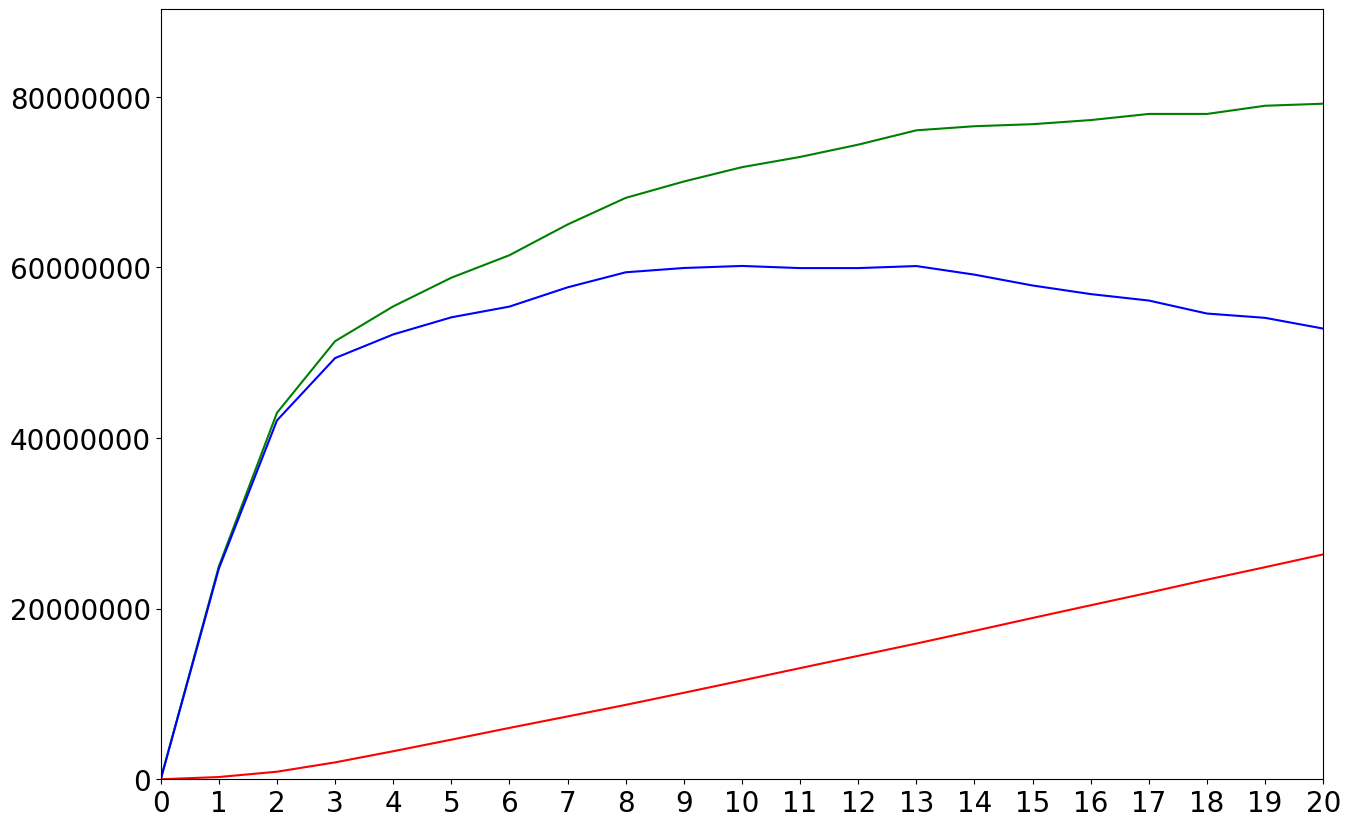

In [67]:
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [68]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,126.0,22.0,104.0,17.460317,82.539683,126.0,22.0,104.0,0.179139,29.213483,29.034345,0.211538
2,2.0,127.0,52.0,75.0,40.944882,59.055118,253.0,74.0,179.0,0.602557,50.280899,49.678342,0.413408
3,3.0,126.0,91.0,35.0,72.222222,27.777778,379.0,165.0,214.0,1.343539,60.112360,58.768821,0.771028
4,4.0,126.0,109.0,17.0,86.507937,13.492063,505.0,274.0,231.0,2.231089,64.887640,62.656552,1.186147
5,5.0,127.0,113.0,14.0,88.976378,11.023622,632.0,387.0,245.0,3.151209,68.820225,65.669016,1.579592
6,6.0,126.0,115.0,11.0,91.269841,8.730159,758.0,502.0,256.0,4.087615,71.910112,67.822497,1.960938
7,7.0,127.0,112.0,15.0,88.188976,11.811024,885.0,614.0,271.0,4.999593,76.123596,71.124003,2.265683
8,8.0,126.0,113.0,13.0,89.682540,10.317460,1011.0,727.0,284.0,5.919713,79.775281,73.855568,2.559859
9,9.0,126.0,118.0,8.0,93.650794,6.349206,1137.0,845.0,292.0,6.880547,82.022472,75.141925,2.893836


In [69]:
FDR.to_csv('FDR.csv')

In [70]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [72]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

12281.0 356.0 12637.0 12637.0


In [73]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

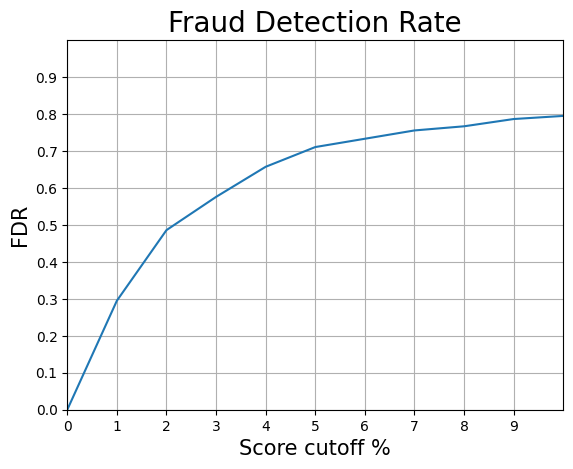

In [71]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(0,1,step=.1))
plt.grid()
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

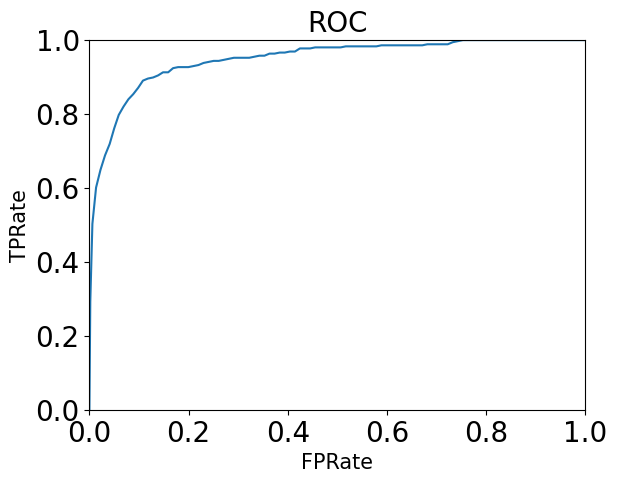

In [74]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [75]:
print("duration: ", datetime.now() - start_time)

duration:  0:27:03.939145


In [76]:
%pwd

'/home/skondakindi/private'

In [80]:
%%time
df = pd.read_csv('card transactions_2025.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 224 ms, sys: 20.3 ms, total: 244 ms
Wall time: 243 ms


<timed exec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(98037, 10)

In [81]:
df['prediction'] = model.predict_proba(X)[:,1]

In [82]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [83]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.002146
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.002705
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.003344
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.002146
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.002155


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98037 entries, 0 to 98392
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             98037 non-null  int64         
 1   Cardnum            98037 non-null  int64         
 2   Date               98037 non-null  datetime64[ns]
 3   Merchnum           94791 non-null  object        
 4   Merch description  98037 non-null  object        
 5   Merch state        97000 non-null  object        
 6   Merch zip          93664 non-null  float64       
 7   Transtype          98037 non-null  object        
 8   Amount             98037 non-null  float64       
 9   Fraud              98037 non-null  int64         
 10  prediction         98037 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 9.0+ MB


In [85]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
42931,42932,5142111125,2010-06-06,5725000466504,CDW*GOVERNMENT INC,IL,60061.0,P,4659.74,1,1.000000
20668,20669,5142214614,2010-03-20,4591200814444,DELL MARKETING L.P.,TX,78682.0,P,5131.83,1,0.998717
71354,71355,5142220919,2010-09-05,335999516224,OFFICE LINK,MD,20910.0,P,4426.72,1,0.998400
20643,20644,5142214614,2010-03-20,6635700620033,STAN OFF/STAN BUS FURN,DC,20011.0,P,4524.53,1,0.998386
63483,63484,5142182128,2010-08-11,7593860048779,BUYPCSOFT.COM,TX,77459.0,P,4527.93,1,0.998265
20651,20652,5142214614,2010-03-20,970611866225,MATH SOFT INC,WA,98109.0,P,4102.37,1,0.997293
20581,20582,5142214614,2010-03-20,4269000010976,A AND L PARTS INCORPORATD,MI,48106.0,P,5165.28,1,0.997143
42902,42903,5142111125,2010-06-06,4574100694444,DELL MARKETING L.P.,TX,78682.0,P,5815.19,1,0.997127
70894,70895,5142225264,2010-09-02,7965600643306,"ACCUSTANDARD, INC",CT,6513.0,P,10.78,1,0.997110
20684,20685,5142214614,2010-03-20,4063000739258,PC *PC CONNECTION,NH,97213.0,P,5266.05,1,0.997065


# Here we're going to look at specific cards or merchants to look at the dynamics of the fraud score

In [86]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142223373    42
5142197711    42
5142220474    42
5142189341    41
5142225942    41
5142160778    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
Name: count, dtype: int64

In [87]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     205
4353000719908    118
9900020006406     51
9108234610000     50
8834000695423     46
4503738417400     45
4620009957157     41
4503082476300     40
900009045549      37
618901687330      36
253052983001      35
938909877224      32
6006333528866     30
997674930332      30
6070095870009     28
Name: count, dtype: int64

In [88]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
sample = df[df['Cardnum'] == card]
# sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

46

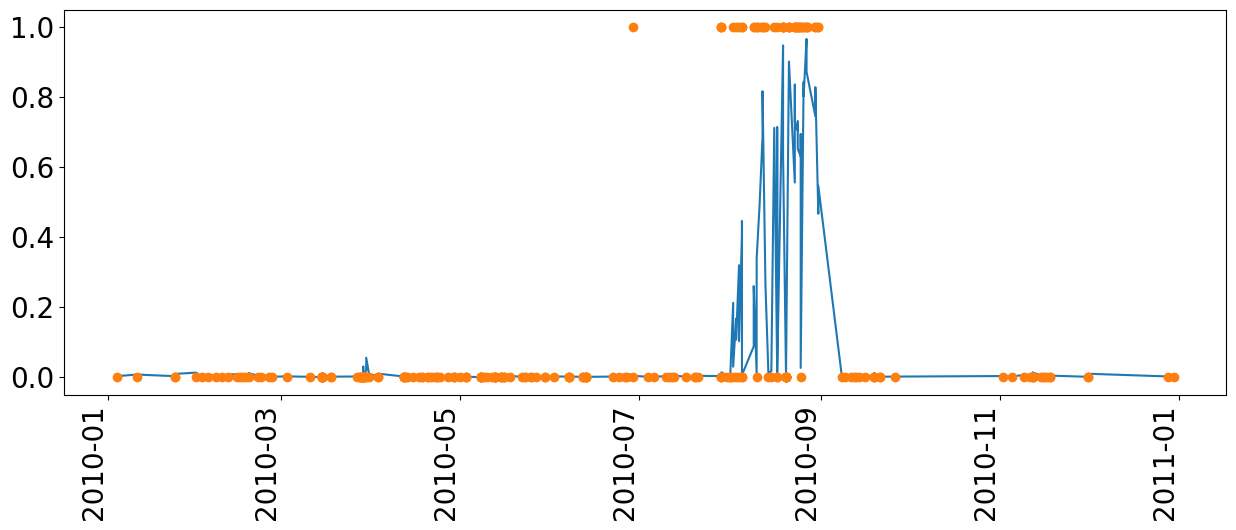

In [89]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [90]:
tsample = sample[sample['Date'] > '2010-08-01']
tsample = tsample[tsample['Date'] < '2010-09-10']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59783,59784,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.212184
1,2,60129,60130,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.029454
2,3,60239,60240,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.166649
3,4,60580,60581,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.106292
4,5,60698,60699,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.319436


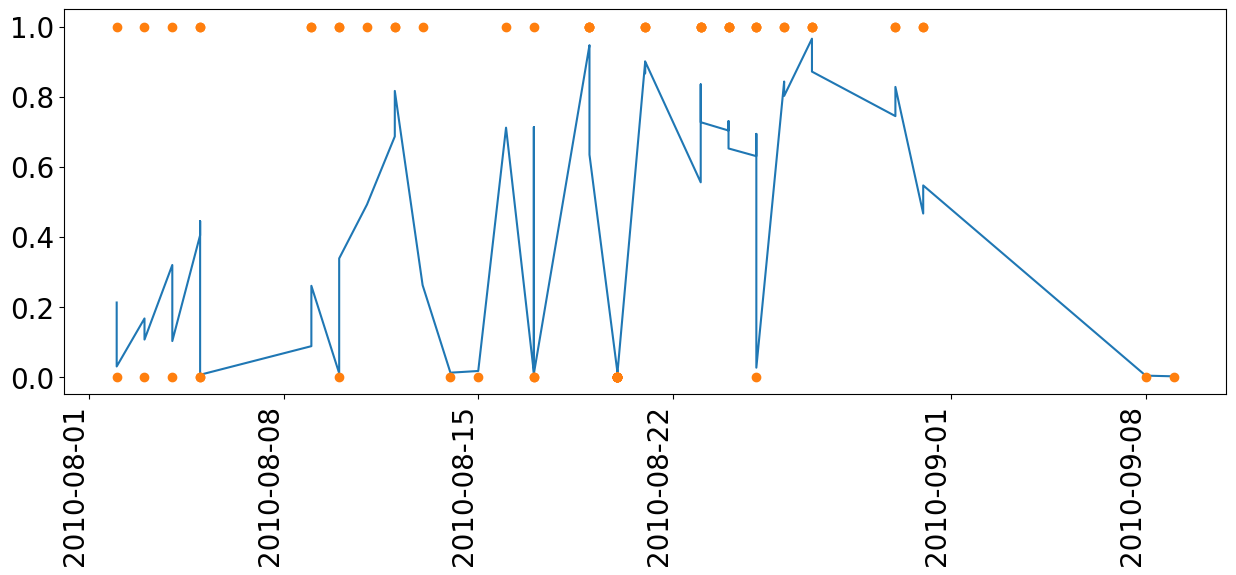

In [91]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])
plt.savefig('dynamics_time.png', format='png')

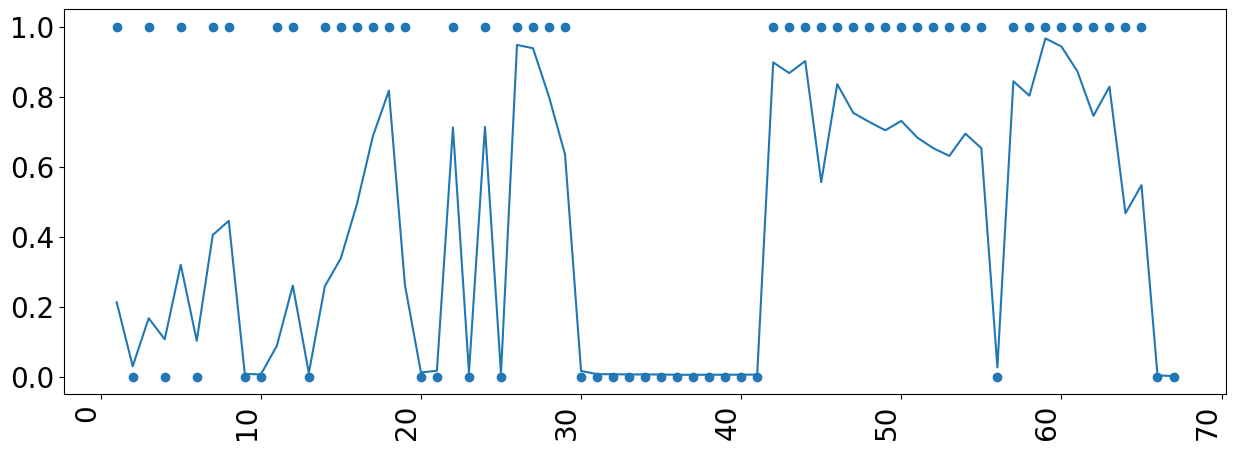

In [92]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])
plt.savefig('dynamics_count.png', format='png')

In [93]:
tsample.to_csv('dynamics_transactions.csv')
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59783,59784,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.212184
1,2,60129,60130,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.029454
2,3,60239,60240,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.166649
3,4,60580,60581,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.106292
4,5,60698,60699,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.319436
5,6,60993,60994,5142140316,2010-08-04,4620002006336,HP GSA STORE,AZ,85285.0,P,1060.00,0,0.102124
6,7,61041,61042,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,629.09,1,0.404464
7,8,61044,61045,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,1821.05,1,0.444720
8,9,61111,61112,5142140316,2010-08-05,930090121224,FEDEX SHP 07/24/10 AB#,TN,38118.0,P,5.16,0,0.007760
9,10,61145,61146,5142140316,2010-08-05,930090121224,FEDEX SHP 07/21/10 AB#,TN,38118.0,P,3.57,0,0.005753


In [94]:
len(tsample)

67

# Score Calibration

In [95]:
base = 600
delta = 20
odds_at_base = .1

In [96]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(98037, 12)

In [97]:
df.head()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,predicted,Fraud
13639,-0.462456,0.015897,-1.077732,0.640092,0.919760,-1.362685,-0.573929,-0.133536,0.299521,0.298578,0.006048,0.0
47497,0.760507,-0.180653,-1.079239,-0.537262,0.919760,-1.083701,-0.474807,1.059685,0.744829,0.743674,0.004787,0.0
46986,-0.462456,-0.199774,-0.732191,-0.089983,-0.445338,-0.525732,-0.124966,-0.730147,-0.591096,-0.591614,0.003039,0.0
14206,-0.462456,-0.210772,-1.111940,-0.111456,-1.264397,-0.944209,-0.637233,-0.431842,-0.591096,-0.591614,0.003067,0.0
31020,-0.462456,0.077170,1.299601,-0.277324,0.919760,1.148172,-0.329040,-0.431842,-0.145788,-0.146518,0.007267,0.0


In [98]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

/tmp/ipykernel_731/1461524955.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_raw'].clip(upper=.999, inplace=True)
/tmp/ipykernel_731/1461524955.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

,score_raw,Fraud
36860,0.000146,0.0
41966,0.000151,0.0
22978,0.000153,0.0
11932,0.000154,0.0
52787,0.000154,0.0


In [99]:
calib.shape

(98037, 2)

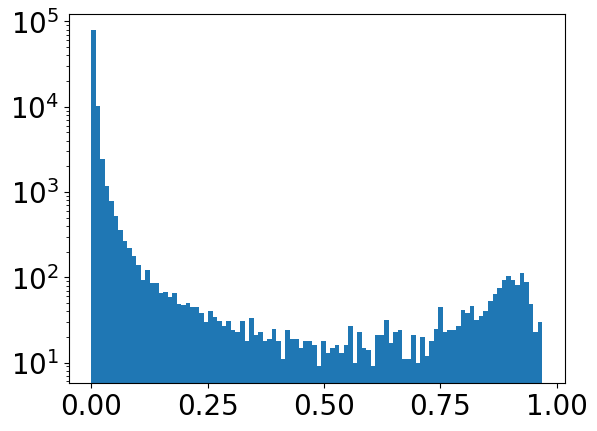

In [100]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [101]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [102]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2492.0 95545.0


In [103]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,980.0,980.0,0.0,100.000000,0.000000,980.0,980.0,0.0,0.000235,0.000000,0.000001,-19.902422,-8.000000
2,2.0,981.0,981.0,0.0,100.000000,0.000000,1962.0,1961.0,0.0,0.000324,0.000000,0.000001,-19.903894,-8.000000
3,3.0,980.0,980.0,0.0,100.000000,0.000000,2940.0,2941.0,0.0,0.000414,0.000000,0.000001,-19.902422,-8.000000
4,4.0,980.0,980.0,0.0,100.000000,0.000000,3920.0,3921.0,0.0,0.000489,0.000000,0.000001,-19.902422,-8.000000
5,5.0,981.0,981.0,0.0,100.000000,0.000000,4905.0,4902.0,0.0,0.000559,0.000000,0.000001,-19.903894,-8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,981.0,916.0,65.0,93.374108,6.625892,94176.0,93609.0,507.0,0.057983,6.625892,0.070962,-3.816814,-3.816814
97,97.0,980.0,851.0,129.0,86.836735,13.163265,95060.0,94460.0,636.0,0.095372,13.163265,0.151588,-2.721777,-2.721777
98,98.0,980.0,702.0,278.0,71.632653,28.367347,96040.0,95162.0,914.0,0.218011,28.367347,0.396013,-1.336381,-1.336381
99,99.0,981.0,294.0,687.0,29.969419,70.030581,97119.0,95456.0,1601.0,0.610536,70.030581,2.336738,1.224496,1.224496


In [104]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,981.0,916.0,65.0,93.374108,6.625892,94176.0,93609.0,507.0,0.057983,6.625892,0.070962,-3.816814,-3.816814
97,97.0,980.0,851.0,129.0,86.836735,13.163265,95060.0,94460.0,636.0,0.095372,13.163265,0.151588,-2.721777,-2.721777
98,98.0,980.0,702.0,278.0,71.632653,28.367347,96040.0,95162.0,914.0,0.218011,28.367347,0.396013,-1.336381,-1.336381
99,99.0,981.0,294.0,687.0,29.969419,70.030581,97119.0,95456.0,1601.0,0.610536,70.030581,2.336738,1.224496,1.224496
100,100.0,980.0,89.0,891.0,9.081633,90.918367,98000.0,95545.0,2492.0,0.898085,90.918367,10.011247,3.323550,3.323550


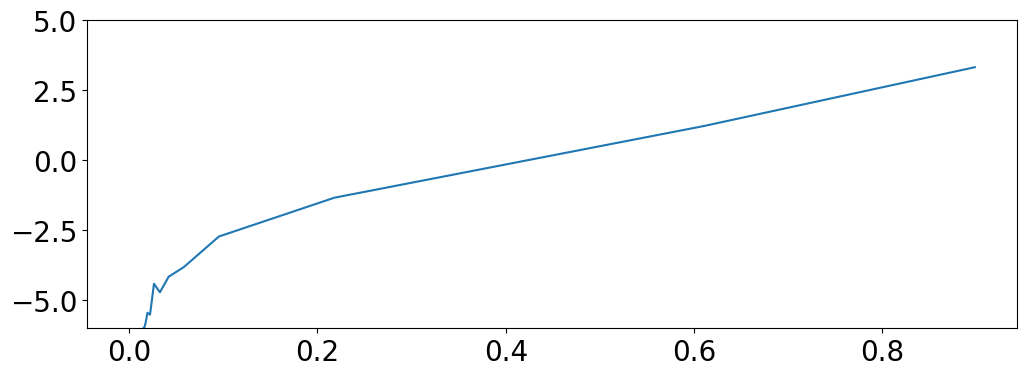

In [105]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [106]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [107]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[0.77227319 0.91635793 0.00139563]


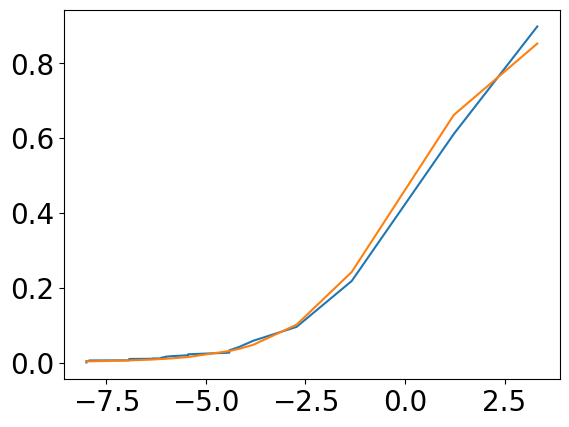

In [108]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


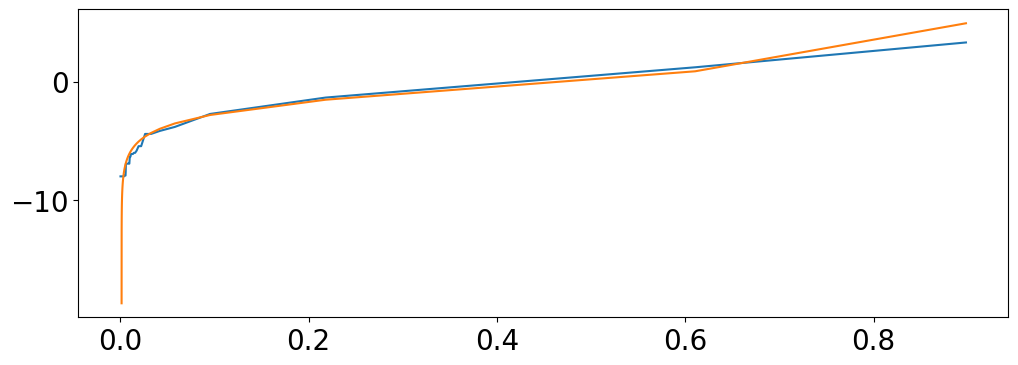

In [109]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [110]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,980.0,980.0,0.0,100.0,0.0,980.0,980.0,0.0,0.000235,0.0,0.000001,-19.902422,-8.0,NaN
2,2.0,981.0,981.0,0.0,100.0,0.0,1962.0,1961.0,0.0,0.000324,0.0,0.000001,-19.903894,-8.0,NaN
3,3.0,980.0,980.0,0.0,100.0,0.0,2940.0,2941.0,0.0,0.000414,0.0,0.000001,-19.902422,-8.0,NaN
4,4.0,980.0,980.0,0.0,100.0,0.0,3920.0,3921.0,0.0,0.000489,0.0,0.000001,-19.902422,-8.0,NaN
5,5.0,981.0,981.0,0.0,100.0,0.0,4905.0,4902.0,0.0,0.000559,0.0,0.000001,-19.903894,-8.0,NaN
6,6.0,980.0,980.0,0.0,100.0,0.0,5880.0,5882.0,0.0,0.000627,0.0,0.000001,-19.902422,-8.0,NaN
7,7.0,981.0,981.0,0.0,100.0,0.0,6867.0,6863.0,0.0,0.000697,0.0,0.000001,-19.903894,-8.0,NaN
8,8.0,980.0,980.0,0.0,100.0,0.0,7840.0,7843.0,0.0,0.000763,0.0,0.000001,-19.902422,-8.0,NaN
9,9.0,980.0,980.0,0.0,100.0,0.0,8820.0,8823.0,0.0,0.000822,0.0,0.000001,-19.902422,-8.0,NaN
10,10.0,981.0,981.0,0.0,100.0,0.0,9810.0,9804.0,0.0,0.000882,0.0,0.000001,-19.903894,-8.0,NaN


In [111]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

/tmp/ipykernel_731/1415719438.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cal_bins['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_731/1415719438.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [112]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
71,71.0,980.0,976.0,4.0,99.591837,0.408163,69580.0,69512.0,94.0,0.007040,0.408163,0.004099,-7.930377,-6.924632,-6.582535,534.787863
72,72.0,981.0,976.0,5.0,99.490316,0.509684,70632.0,70488.0,99.0,0.007280,0.509684,0.005124,-7.608521,-6.924632,-6.528310,535.872368
73,73.0,980.0,973.0,7.0,99.285714,0.714286,71540.0,71461.0,106.0,0.007534,0.714286,0.007195,-7.118735,-6.924632,-6.473216,536.974238
74,74.0,980.0,976.0,4.0,99.591837,0.408163,72520.0,72437.0,110.0,0.007788,0.408163,0.004099,-7.930377,-6.924632,-6.420345,538.031671
75,75.0,981.0,974.0,7.0,99.286442,0.713558,73575.0,73411.0,117.0,0.008068,0.713558,0.007188,-7.120217,-6.924632,-6.364579,539.146982
76,76.0,980.0,975.0,5.0,99.489796,0.510204,74480.0,74386.0,122.0,0.008360,0.510204,0.005129,-7.607042,-6.924632,-6.308581,540.266950
77,77.0,980.0,977.0,3.0,99.693878,0.306122,75460.0,75363.0,125.0,0.008681,0.306122,0.003072,-8.346771,-6.924632,-6.249818,541.442195
78,78.0,981.0,977.0,4.0,99.592253,0.407747,76518.0,76340.0,129.0,0.008996,0.407747,0.004095,-7.931854,-6.924632,-6.194614,542.546279
79,79.0,980.0,974.0,6.0,99.387755,0.612245,77420.0,77314.0,135.0,0.009310,0.612245,0.006161,-7.342575,-6.924632,-6.141653,543.605507
80,80.0,981.0,974.0,7.0,99.286442,0.713558,78480.0,78288.0,142.0,0.009644,0.713558,0.007188,-7.120217,-6.924632,-6.087742,544.683729


In [113]:
calib.head()

,score_raw,Fraud
36860,0.000146,0.0
41966,0.000151,0.0
22978,0.000153,0.0
11932,0.000154,0.0
52787,0.000154,0.0


In [114]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

/tmp/ipykernel_731/2868135245.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  calib['score_calib'].fillna(999, inplace=True)
/tmp/ipykernel_731/2868135245.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,score_raw,Fraud,score_calib
36860,0.000146,0.0,675.630571
41966,0.000151,0.0,675.630588
22978,0.000153,0.0,675.630596
11932,0.000154,0.0,675.630598
52787,0.000154,0.0,675.630598


In [115]:
calib.tail()

,score_raw,Fraud,score_calib
63264,0.967198,1.0,678.901667
20610,0.967315,1.0,678.902030
71097,0.967328,1.0,678.902071
20635,0.967635,1.0,678.903019
42797,0.968879,1.0,678.906856


In [116]:
calib.describe()

,score_raw,Fraud,score_calib
count,98037.000000,98037.000000,98037.000000
mean,0.024282,0.025419,675.714272
std,0.110207,0.157395,0.377437
min,0.000146,0.000000,675.630571
25%,0.001795,0.000000,675.636404
50%,0.003735,0.000000,675.643268
75%,0.008213,0.000000,675.659115
max,0.968879,1.000000,678.906856


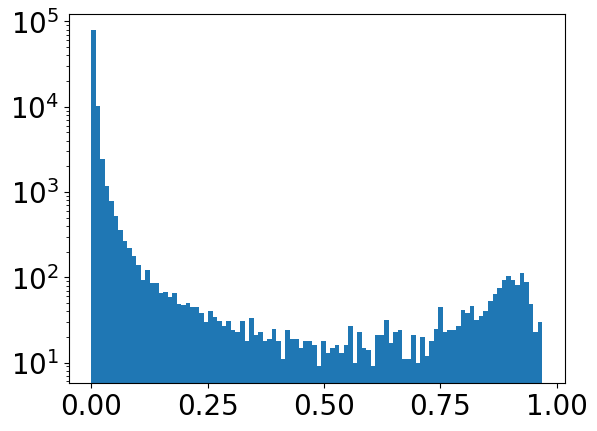

In [117]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

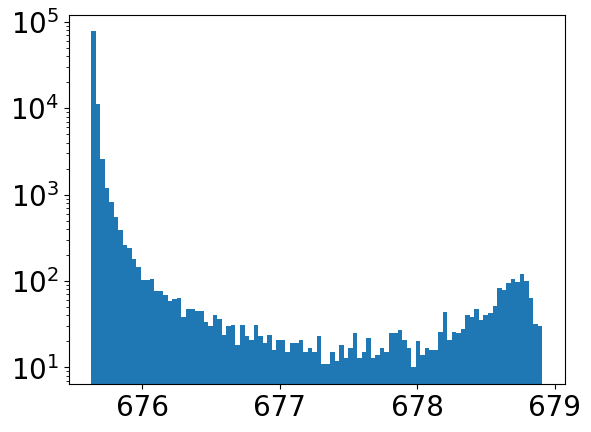

In [118]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

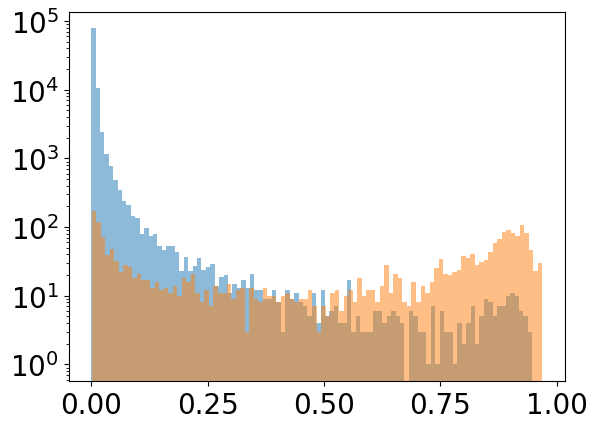

In [119]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

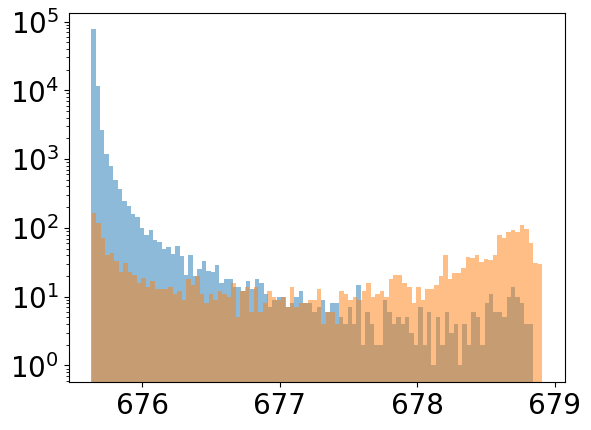

In [120]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [121]:
import scipy.stats as sps
KS = sps.ks_2samp(goods['score_raw'],bads['score_raw'])[0]
print(KS)

0.8176332708856945


In [122]:
print("duration: ", datetime.now() - start_time)

duration:  0:32:21.119238


In [123]:
%pwd

'/home/skondakindi/private'